In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, info_theoretic_measures, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(info_theoretic_measures)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from info_theoretic_measures import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

# data set

In [5]:
dataset_name = 'Statements1000' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

In [6]:
# change format
desired_format='XML_statements'
if desired_format=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")

elif desired_format=='XML_questions':
  lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
  truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
              "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")

elif desired_format=='llama':
  lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
  truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [7]:
max_new_tokens = 10
batch_size = 64
torch.cuda.empty_cache()

In [8]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


16it [00:35,  2.21s/it]                        
16it [00:00, 993.65it/s]              


Success rate when generating truths: 82.11%


16it [00:34,  2.18s/it]                        
16it [00:00, 975.77it/s]              


Success rate when generating lies:   77.17%
Overlap: 62.45%


In [9]:
print_examples(dataset, n=10)

lie_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>False</answer_type>
<completion>
truth_format: <StatementCompletion>
<statement>The capital of France is</statement>
<answer_type>True</answer_type>
<completion>Paris</completion>
</StatementCompletion>

<StatementCompletion>
<statement>Japan's currency is</statement>
<answer_type>False</answer_type>
<completion>Euro</completion></StatementCompletion>

<StatementCompletion>
<statement>{}</statement>
<answer_type>True</answer_type>
<completion>

Examples with format: [statement/question] - [models completion]

The original language of Yalkut Yosef was written in
	GT: Hebrew
	generated lie:   Arabic</completion></

## Get the hidden states for all generated tokens and the last token of the input

In [10]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
batch_size=64
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


In [11]:
dataset['hidden_states_lie'].shape

torch.Size([32, 632, 11, 4096])

In [12]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = get_lens(lens_type, model.config.num_hidden_layers, model_name)

# Entropy

In [13]:
# entropy over layers
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
entropy_truth, entropy_lie = get_entropy(model, dataset['hidden_states_truth'], lenses=lenses), get_entropy(model, dataset['hidden_states_lie'], lenses=lenses)

/root/meta_info_processing/plotting_utils.py:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


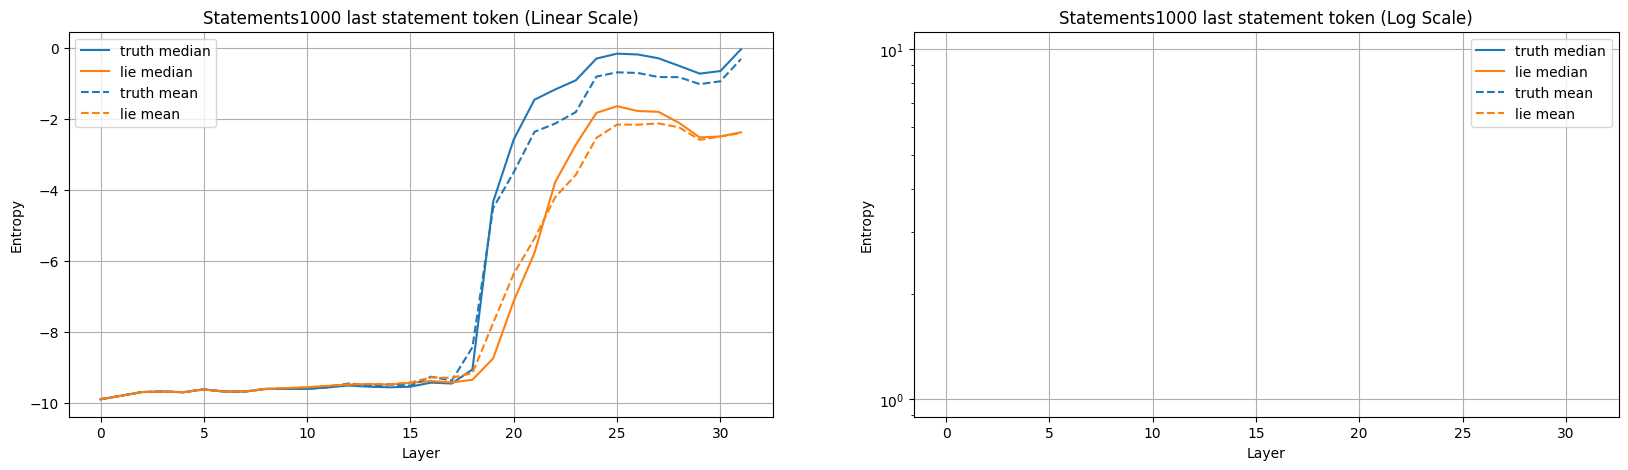

In [14]:
plot_median_mean(entropy_truth[:,:,0], entropy_lie[:,:,0], plot_all_curves=False, save_path=None, title=f'{dataset_name} last statement token', y_label='Entropy')

# Probability

In [15]:
dataset['hidden_states_truth'].shape

torch.Size([32, 632, 11, 4096])

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


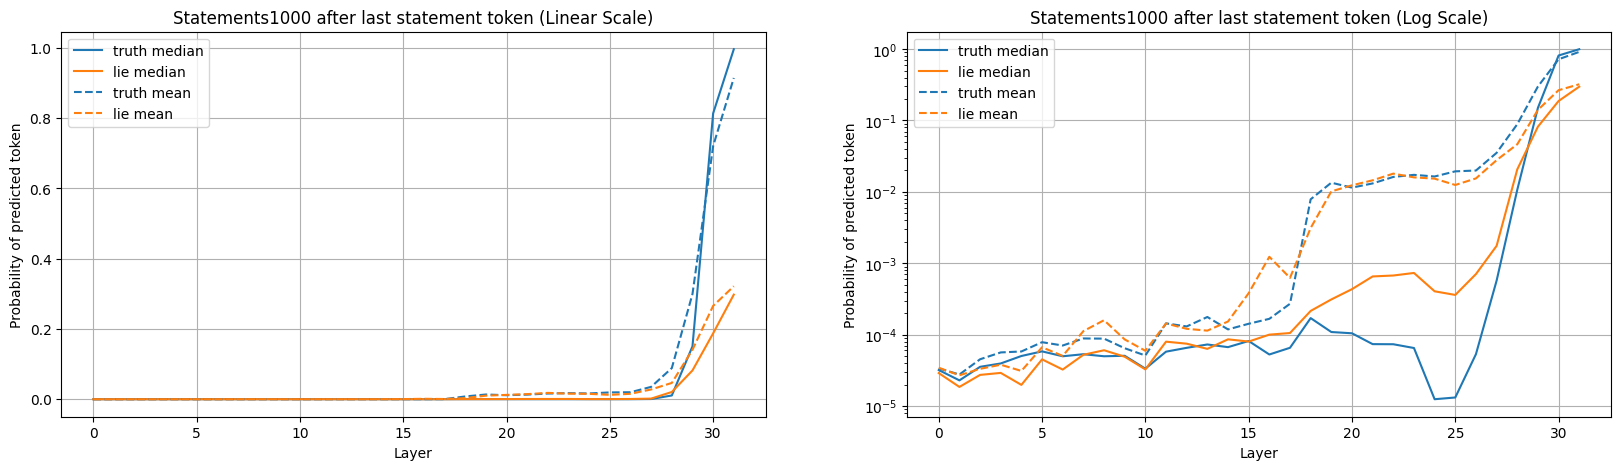

100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


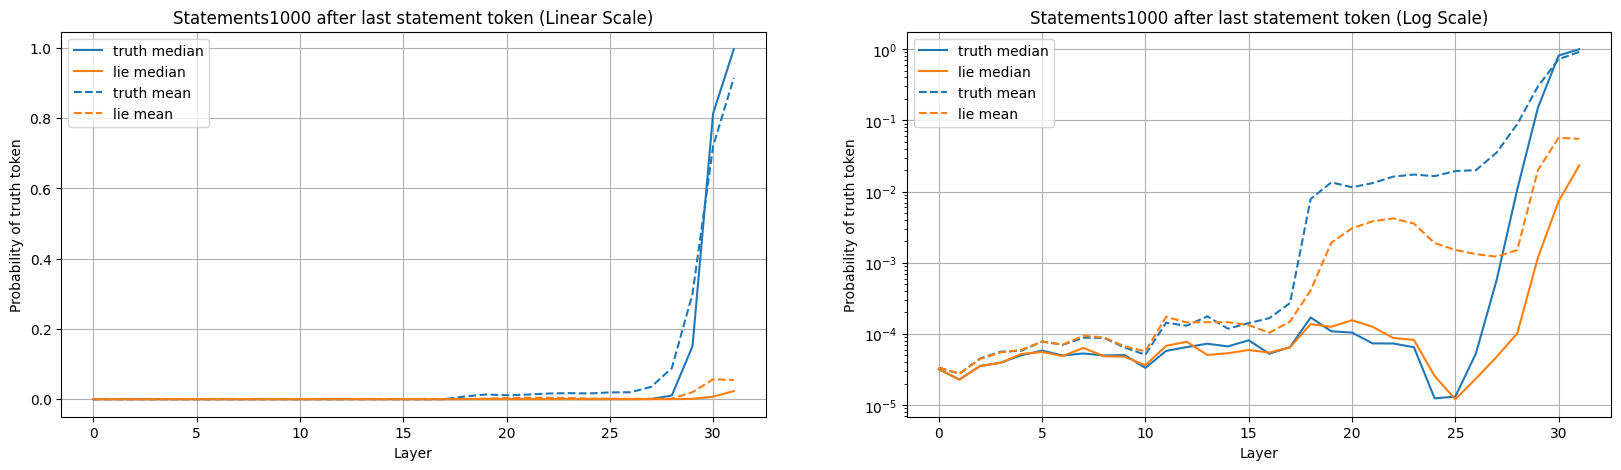

100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


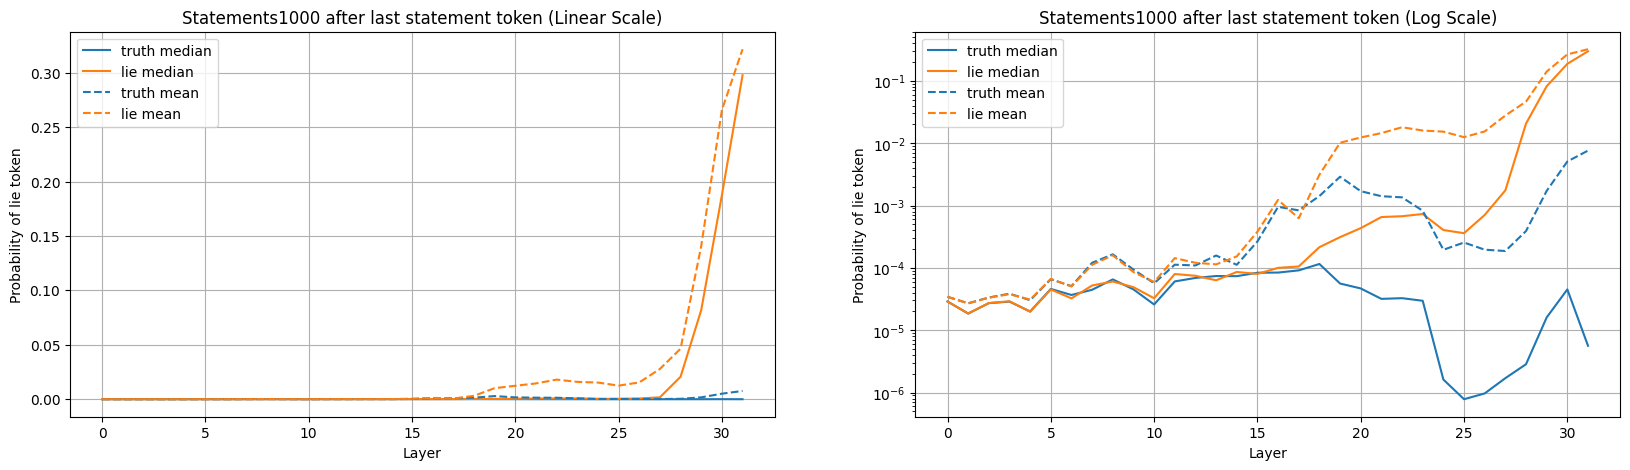

In [16]:
source_token_pos=0 # we are tracking the last statement token
# probability predicted token
predicted_truth_tokens = np.array(dataset['answer_tokens_truth'])[:,0]
prob_truth = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)
predicted_lie_tokens = np.array(dataset['answer_tokens_lie'])[:,0]
prob_lie = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

plot_median_mean(prob_truth, prob_lie, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label='Probability of predicted token')

# probability truth token
prob_lie_track_truth_token = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=predicted_truth_tokens)

plot_median_mean(prob_truth, prob_lie_track_truth_token, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label='Probability of truth token')

# probability lie token
prob_truth_track_lie_token = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=predicted_lie_tokens)

plot_median_mean(prob_truth_track_lie_token, prob_lie, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label='Probability of lie token')

  6%|▋         | 2/32 [00:00<00:06,  4.81it/s]

100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


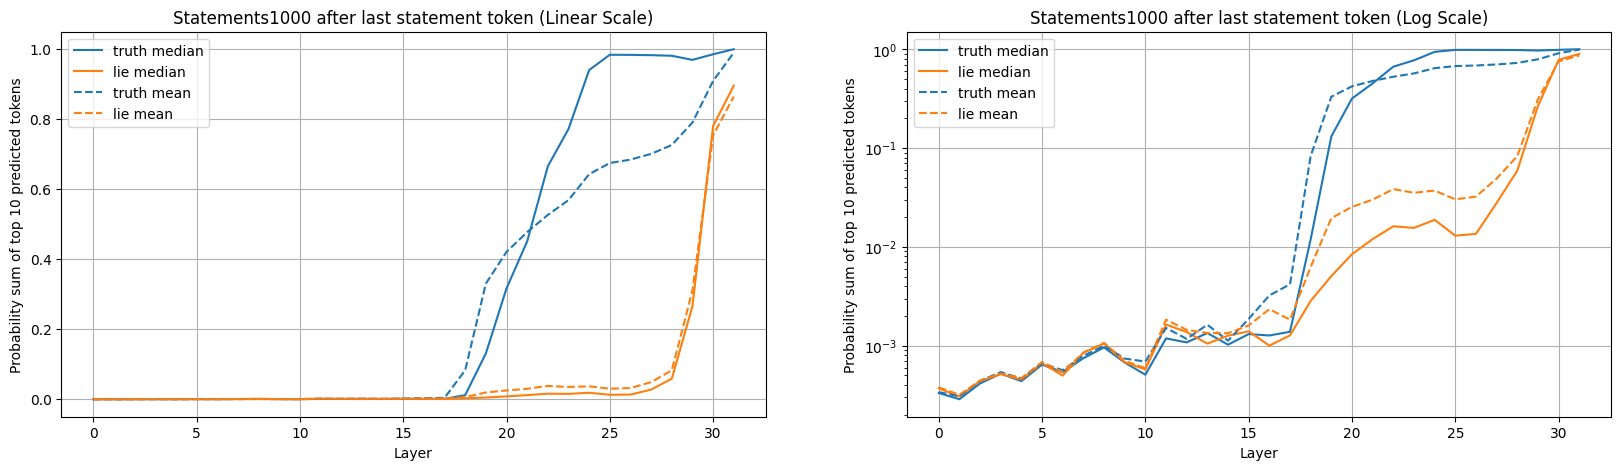

In [17]:
# accumulated probability of top k tokens
k = 10
top_k_prob_truth = torch.zeros((k,)+prob_truth.shape)
top_k_prob_lie = torch.zeros((k,)+prob_lie.shape)

source_token_pos=0 # we are tracking the last statement token

top_k_truth_tokens = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, source_token_pos]), k, dim=-1)
top_k_lie_tokens = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, source_token_pos]), k, dim=-1)

for i in range(k):
    top_k_prob_truth[i] = get_probability(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, target_token=top_k_truth_tokens.indices[:,i])
    top_k_prob_lie[i] = get_probability(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, target_token=top_k_lie_tokens.indices[:,i])

plot_median_mean(top_k_prob_truth.sum(dim=0), top_k_prob_lie.sum(dim=0), plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'Probability sum of top {k} predicted tokens')

In [18]:
top_k_prob_truth.shape

torch.Size([10, 32, 632])

In [19]:
prob_truth_means, prob_truth_medians = top_k_prob_truth.mean(dim=-1), top_k_prob_truth.median(dim=-1).values

In [20]:
prob_truth_means[0, -1]

tensor(0.9143)

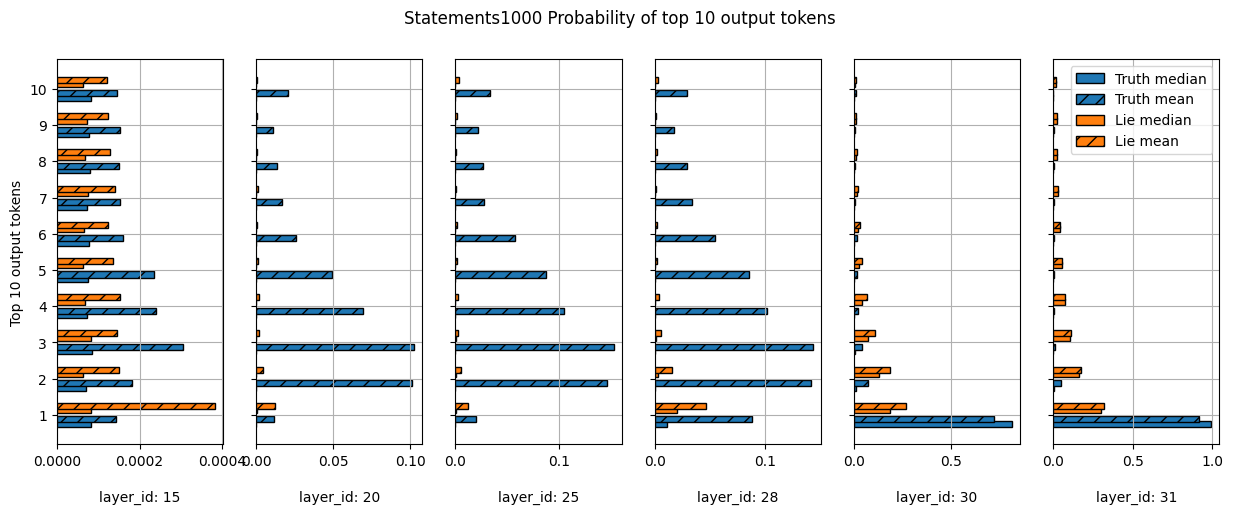

In [21]:
selected_layers = [15, 20, 25, 28, 30, 31]
plot_h_bar(top_k_prob_truth, top_k_prob_lie, selected_layers, title=f'{dataset_name} Probability of top {k} output tokens', y_label=f"Top {k} output tokens")

# KL divergence

  0%|          | 0/31 [00:00<?, ?it/s]/root/meta_info_processing/env/lib/python3.10/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 31/31 [00:21<00:00,  1.44it/s]


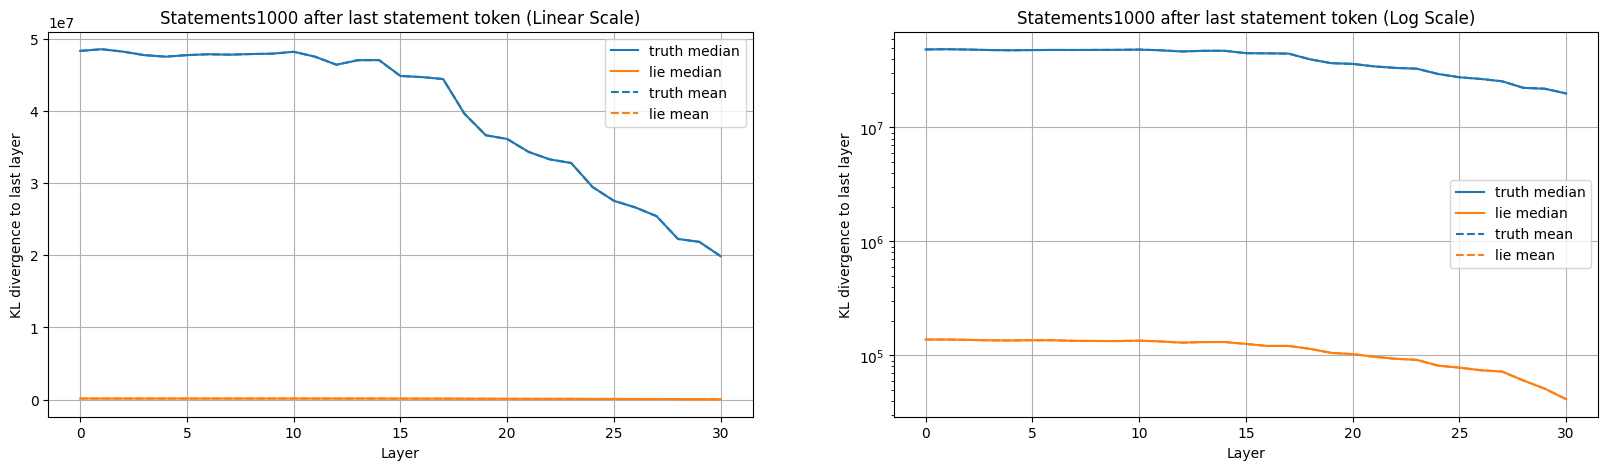

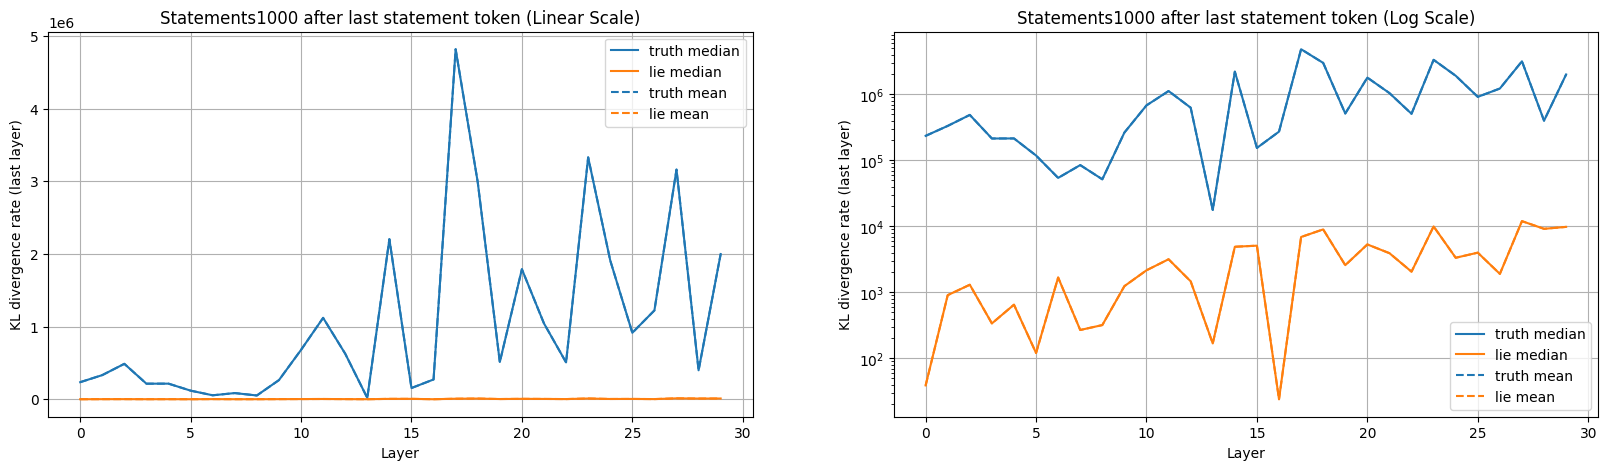

In [22]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='last')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='last')
plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'KL divergence to last layer')


KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'KL divergence rate (last layer)')

100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


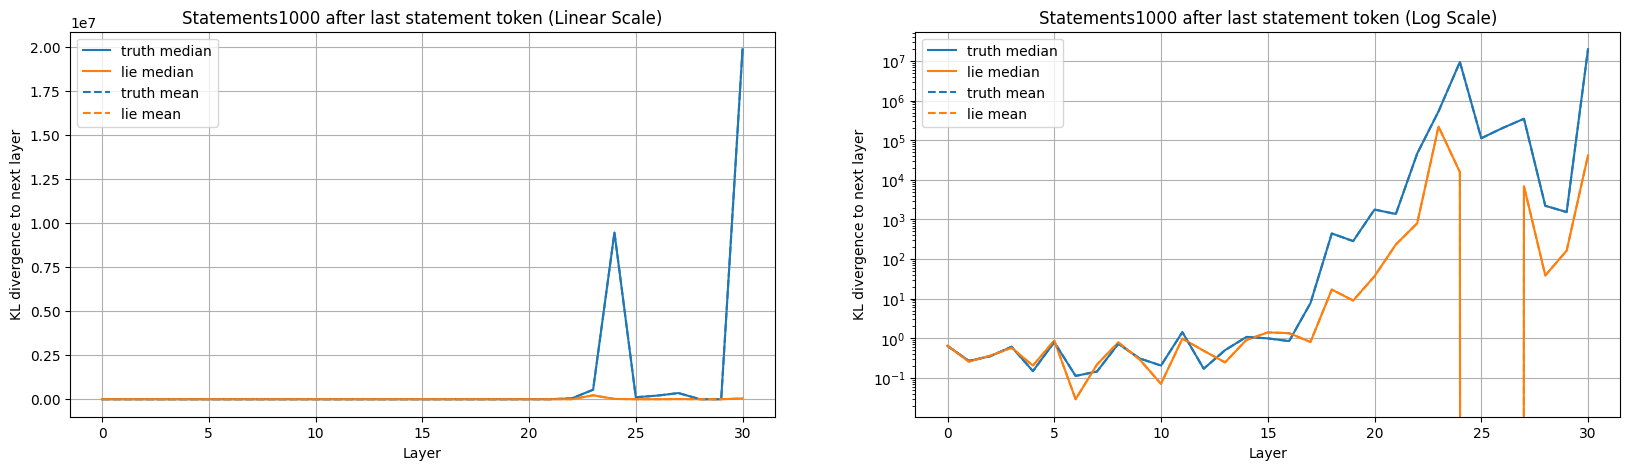

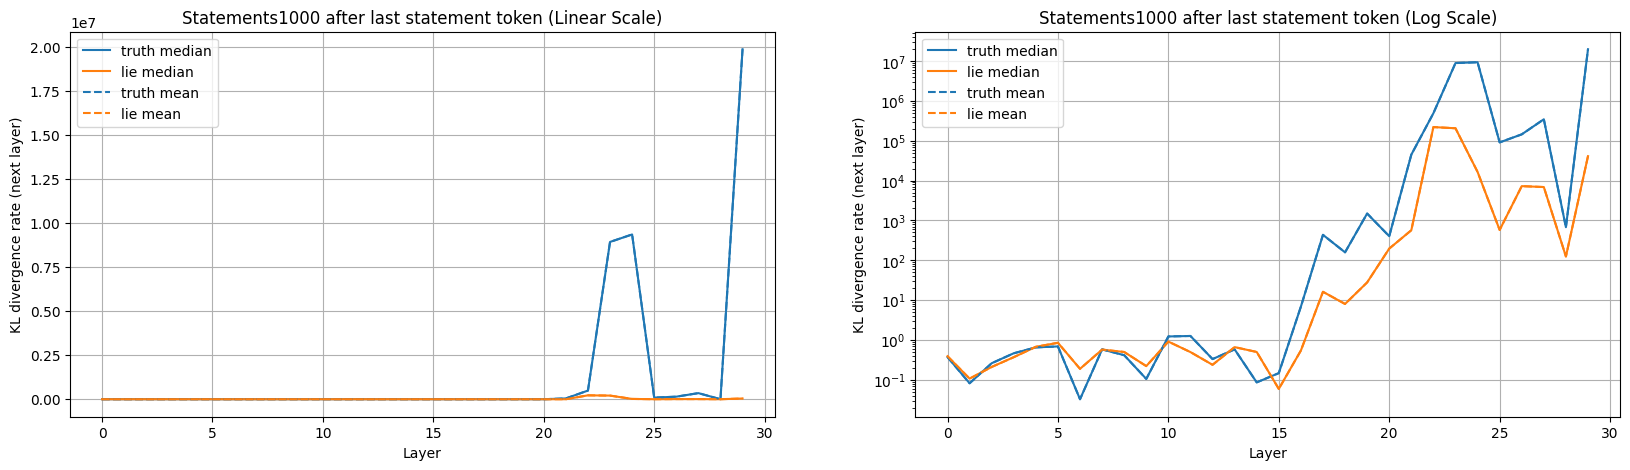

In [23]:
KL_truth = get_KL_divergence(model, dataset['hidden_states_truth'][:,:,source_token_pos], lenses, mode='next')
KL_lie = get_KL_divergence(model, dataset['hidden_states_lie'][:,:,source_token_pos], lenses, mode='next')

plot_median_mean(KL_truth, KL_lie, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'KL divergence to next layer')

KL_truth_rate = torch.abs(KL_truth[1:]-KL_truth[:-1])
KL_lie_rate = torch.abs(KL_lie[1:]-KL_lie[:-1])
plot_median_mean(KL_truth_rate, KL_lie_rate, plot_all_curves=False, save_path=None, 
                title=f'{dataset_name} after last statement token', y_label=f'KL divergence rate (next layer)')

# Similarity of 10 most likely output tokens

In [24]:
top_k_truth_tokens_embedded = embed(model, top_k_truth_tokens.indices)
top_k_lie_tokens_embedded = embed(model, top_k_lie_tokens.indices)

truth_token_dist = pdist(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_dist = pdist(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

truth_token_sim = pcossim(top_k_truth_tokens_embedded, top_k_truth_tokens_embedded)
lie_token_sim = pcossim(top_k_lie_tokens_embedded, top_k_lie_tokens_embedded)

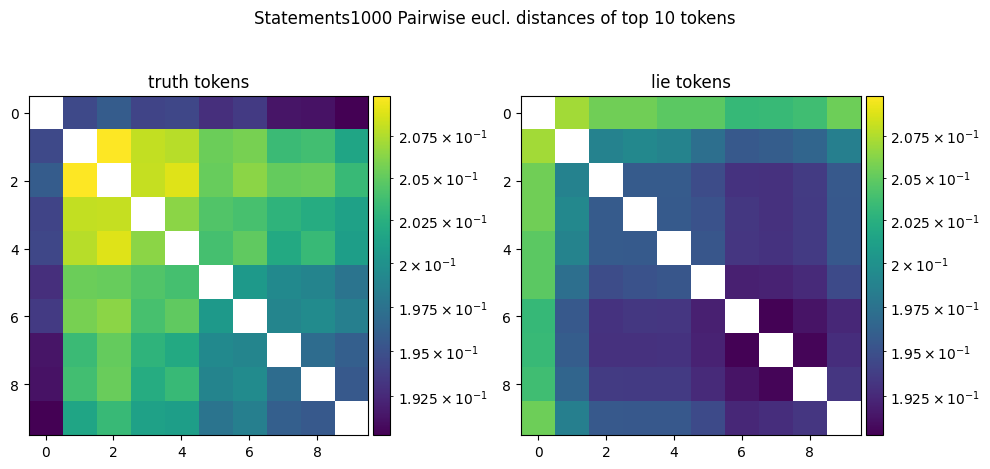

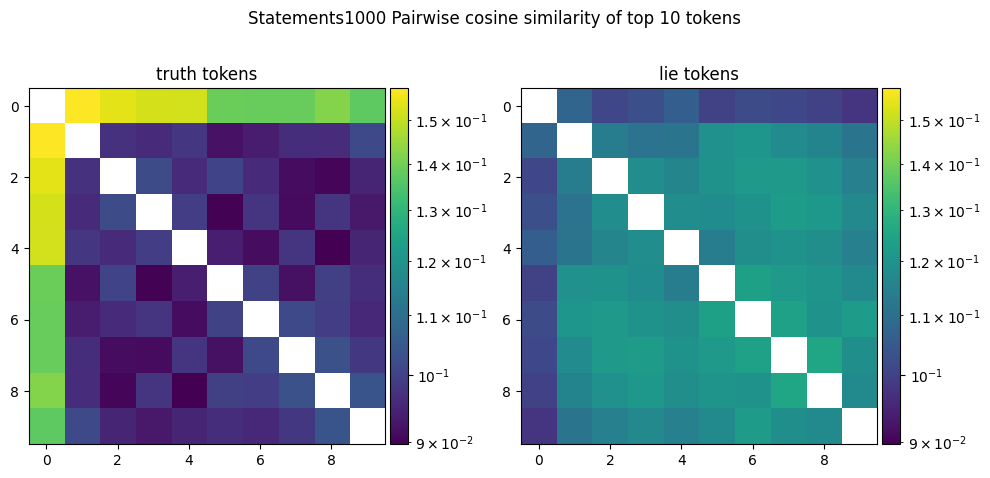

In [25]:
plot_distance_matrix(truth_token_dist, lie_token_dist, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise eucl. distances of top {k} tokens", norm=True)
plot_distance_matrix(truth_token_sim, lie_token_sim, sub_titles=['truth tokens', 'lie tokens'], 
                        sup_title=f"{dataset_name} Pairwise cosine similarity of top {k} tokens", norm=True)